# SENTIMENT ANALYSIS USING CONV-1D

In [1]:
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
import regex as re
import string
import nltk
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
import matplotlib.pyplot as plt

## DATA PREPARATION

In [2]:
trainDS, valDS, testDS = tfds.load('imdb_reviews',
                                   split=['train', 'test[:50%]', 'test[50%:]'],
                                   as_supervised=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/3 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/25000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/plain_text/incomplete.DJQLCA_1.0.0/imdb_reviews-train.tfrecor…

Generating test examples...:   0%|          | 0/25000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/plain_text/incomplete.DJQLCA_1.0.0/imdb_reviews-test.tfrecord…

Generating unsupervised examples...:   0%|          | 0/50000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/plain_text/incomplete.DJQLCA_1.0.0/imdb_reviews-unsupervised.…

Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0. Subsequent calls will reuse this data.


In [3]:
len(trainDS), len(valDS), len(testDS)

(25000, 12500, 12500)

In [4]:
for review, label in trainDS.take(2):
    print('Review:', review.numpy())
    print('Label:', label.numpy())
    print('\n')

Review: b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it."
Label: 0


Review: b'I have been known to fall asleep during films, but this is usually due to a combination of things including, really tired, being warm and comfortable on the sette and having just eaten a lot. However on this occasion I fell asleep because the film was rubbis

In [5]:
def standardization(inputData):
    lowerCaseOutput = tf.strings.lower(inputData)
    noTagOutput = tf.strings.regex_replace(lowerCaseOutput, "<[^>]+>", " ")
    noPunctOutput = tf.strings.regex_replace(noTagOutput, "[%s]" % re.escape(string.punctuation), "")
    return noPunctOutput

In [6]:
VOCAB_SIZE = 10000
SEQUENCE_LENGTH = 250

In [7]:
vectorizer = tf.keras.layers.TextVectorization(
    standardize=standardization,
    max_tokens=VOCAB_SIZE,
    output_sequence_length=SEQUENCE_LENGTH,
    output_mode='int',
)

In [8]:
trainingData = trainDS.map(lambda x, y: x)
vectorizer.adapt(trainingData)

In [9]:
def vectorize(review, label):
    return vectorizer(review), label

In [10]:
trainDS = trainDS.map(vectorize)
valDS = valDS.map(vectorize)

In [11]:
for review, label in trainDS.take(1):
    print('Review:', review.numpy())
    print('Label:', label.numpy())
    print('\n')

Review: [  11   13   33  414  380   17   89   26    1    8   32 1336 3543   41
  489    1  190   23   84  151   18   11  219  318   26   64  241  211
    8  476   53   64   84  111   97   21 5574   11   92  633  729   11
   17    7   33  396 9231  167 2462  408    2   88 1192  135   65  143
   51    2    1 7488   65  247   64 2835   15    1 2869    1    1 1436
 4861    3   39    1 1546   16 3543   13  156   18    4 1192  894 7958
    8    4   17   12   13 4064    5   99  146 1229   10  236  663   12
   47   23   92   38   11 7269  151   38 1336    1   49  397   10   97
 1170  856  140    9    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    

In [12]:
BATCH_SIZE = 64
trainDS = trainDS.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
valDS = valDS.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

## MODELING & TRAINING

### CONV-1D

In [58]:
EMBEDDING_DIM = 64
convModel = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(SEQUENCE_LENGTH,)),
    tf.keras.layers.Embedding(VOCAB_SIZE, EMBEDDING_DIM),

    tf.keras.layers.Conv1D(32, 3, activation='relu'),
    tf.keras.layers.GlobalAveragePooling1D(),

    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1, activation='sigmoid')
], name = "convModel")
convModel.summary()

Model: "convModel"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)              │ (None, 250, 64)             │         640,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_2 (Conv1D)                    │ (None, 248, 32)             │           6,176 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling1d             │ (None, 32)                  │               0 │
│ (GlobalAveragePooling1D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 647,265 (2.47 MB)

 Trainable params: 647,265 (2.47 MB)

 Non-trainable params: 0 (0.00 B)

In [52]:
! mkdir Models

In [59]:
checkpointFilepath = 'Models/convModel.h5'
modelCheckpointCallback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpointFilepath,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True
)

In [60]:
convModel.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

In [61]:
history = convModel.fit(
    trainDS,
    validation_data=valDS,
    epochs=10,
    callbacks=[modelCheckpointCallback]
)

Epoch 1/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.6418 - loss: 0.6002

391/391 ━━━━━━━━━━━━━━━━━━━━ 16s 29ms/step - accuracy: 0.6421 - loss: 0.5999 - val_accuracy: 0.8711 - val_loss: 0.3166
Epoch 2/10
387/391 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.8886 - loss: 0.2871

391/391 ━━━━━━━━━━━━━━━━━━━━ 8s 20ms/step - accuracy: 0.8887 - loss: 0.2869 - val_accuracy: 0.8754 - val_loss: 0.3024
Epoch 3/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 8s 20ms/step - accuracy: 0.9226 - loss: 0.2194 - val_accuracy: 0.8685 - val_loss: 0.3236
Epoch 4/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 8s 20ms/step - accuracy: 0.9407 - loss: 0.1803 - val_accuracy: 0.8638 - val_loss: 0.3566
Epoch 5/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 8s 20ms/step - accuracy: 0.9501 - loss: 0.1562 - val_accuracy: 0.8574 - val_loss: 0.4022
Epoch 6/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 8s 20ms/step - accuracy: 0.9578 - loss: 0.1344 - val_accuracy: 0.8570 - val_loss: 0.4303
Epoch 7/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 8s 20ms/step - accuracy: 0.9638 - loss: 0.1204 - val_accuracy: 0.8514 - val_loss: 0.4940
Epoch 8/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 8s 20ms/step - accuracy: 0.9679 - loss: 0.1021 - val_accuracy: 0.8487 - val_loss: 0.5136
Epoch 9/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 8s 20ms/step - accuracy: 0.9698 - loss: 0.0975 - val_accuracy: 0.841

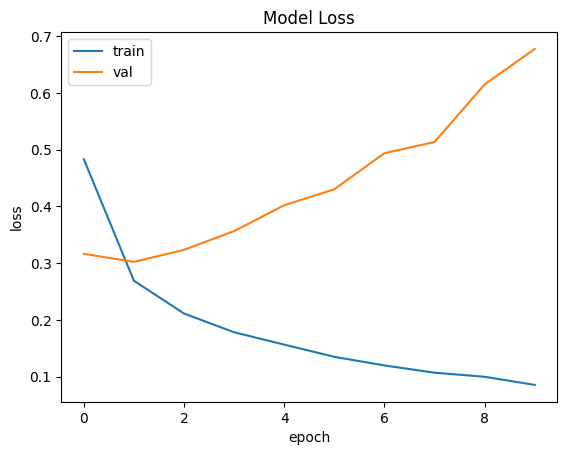

In [62]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

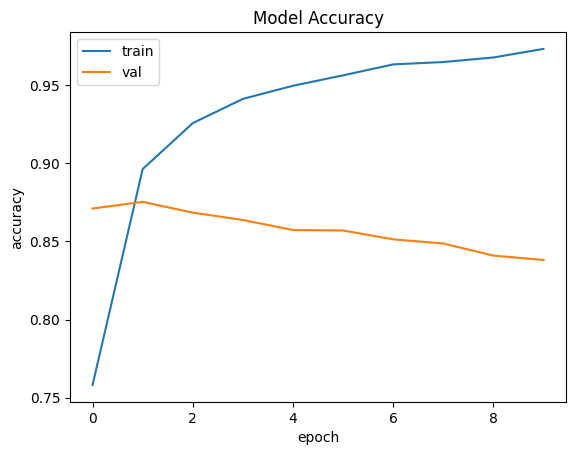

In [63]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [64]:
testDS = testDS.map(vectorize)
testDS = testDS.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
testLoss, testAccuracy = convModel.evaluate(testDS)
print('Test Loss:', testLoss)
print('Test Accuracy:', testAccuracy)

196/196 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.8413 - loss: 0.6882
Test Loss: 0.6734271049499512
Test Accuracy: 0.8420799970626831
